Uber Pickup Project 

In [1]:
#import de bibl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score


In [ ]:
#dataset=pd.read_csv("/content/drive/MyDrive/Machine_learning_non_supervisé/Projets/projet_uber/taxi-zone-lookup.csv")

In [ ]:
#dataset.head()

In [2]:
data=pd.read_csv("uber-raw-data-sep14.csv")

In [3]:
data.shape

(1028136, 4)

In [4]:
data1=data.sample(50000)
df=data1.copy()

In [5]:
df.head()

Date/Time      Lat      Lon    Base
818896   9/25/2014 21:29:00  40.7307 -74.0005  B02682
1016574  9/29/2014 12:44:00  40.7191 -74.0050  B02764
808348   9/24/2014 10:19:00  40.7595 -73.9919  B02682
445166   9/13/2014 20:10:00  40.7475 -73.9967  B02617
995999   9/26/2014 21:28:00  40.7247 -73.9942  B02764

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 818896 to 11513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date/Time  50000 non-null  object 
 1   Lat        50000 non-null  float64
 2   Lon        50000 non-null  float64
 3   Base       50000 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1.9+ MB


In [7]:
df['Base'].unique()

array(['B02682', 'B02764', 'B02617', 'B02598', 'B02512'], dtype=object)

In [8]:
#transforme date/time en datetime
df['Date'] = pd.to_datetime(df['Date/Time'])

In [9]:
df=df.drop('Date/Time',axis=1)
df.head()

Lat      Lon    Base                Date
818896   40.7307 -74.0005  B02682 2014-09-25 21:29:00
1016574  40.7191 -74.0050  B02764 2014-09-29 12:44:00
808348   40.7595 -73.9919  B02682 2014-09-24 10:19:00
445166   40.7475 -73.9967  B02617 2014-09-13 20:10:00
995999   40.7247 -73.9942  B02764 2014-09-26 21:28:00

In [10]:
#Extraire l'heure, le jour, le mois et le jour de semaine
df['hour'] = df['Date'].dt.hour
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek

In [11]:
#

In [12]:
df=df.drop('Date',axis=1)
display(df.head())

Lat      Lon    Base  hour  month  day  dayofweek
818896   40.7307 -74.0005  B02682    21      9   25          3
1016574  40.7191 -74.0050  B02764    12      9   29          0
808348   40.7595 -73.9919  B02682    10      9   24          2
445166   40.7475 -73.9967  B02617    20      9   13          5
995999   40.7247 -73.9942  B02764    21      9   26          4

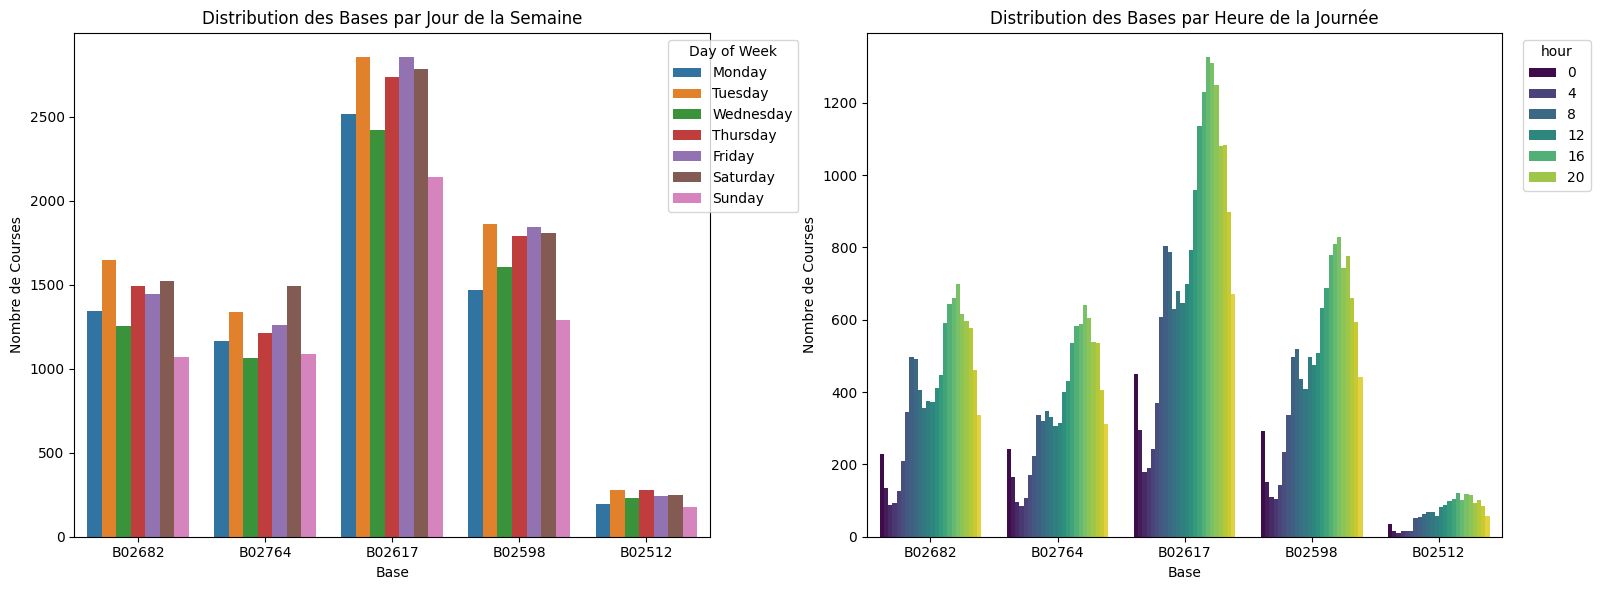

In [13]:
# Création de la figure et des axes
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Premier graphique : Comptage des bases par jour de la semaine
sns.countplot(data=df, x='Base', hue='dayofweek', ax=ax[0], palette='tab10')
ax[0].legend(title='Day of Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], loc='upper right', bbox_to_anchor=(1.15, 1))
ax[0].set_title('Distribution des Bases par Jour de la Semaine')
ax[0].set_xlabel('Base')
ax[0].set_ylabel('Nombre de Courses')

# Second graphique : Comptage des bases par heure
sns.countplot(data=df, x='Base', hue='hour', ax=ax[1], palette='viridis')
ax[1].legend(title='hour', loc='upper right', bbox_to_anchor=(1.15, 1))
ax[1].set_title('Distribution des Bases par Heure de la Journée')
ax[1].set_xlabel('Base')
ax[1].set_ylabel('Nombre de Courses')

# Ajustement des espacements pour éviter le chevauchement
plt.tight_layout()

# Affichage de la figure
plt.show()

Le nombre de courses differes selon la base et le jour de semaine ainsi que l'heure.
et par contre j'observe la meme tendance pour toutes les bases.

In [14]:

fig = px.scatter_mapbox(df,lat='Lat',
                        lon='Lon',
                        color="Base",
                        mapbox_style="carto-positron",
                        zoom=10)


fig.update_layout(
    title='Distribution des Courses par Base',
    mapbox_style='open-street-map')


fig.show()

In [15]:

fig = px.scatter_mapbox(df,lat='Lat',
                        lon='Lon',
                        color="hour",
                        mapbox_style="carto-positron",
                        zoom=10)


fig.update_layout(
    title='Distribution des Courses par Heure',
    mapbox_style='open-street-map')


fig.show()

Je constate une concentration d'activité au niveau de Manhattan, Brooklyn et le nord de Queens.

In [16]:
numeric_features=["Lat","Lon"]
categorical_features=["hour","dayofweek"]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ])

In [17]:
cols=["Lat","Lon","hour","dayofweek"]

In [18]:
X=preprocessor.fit_transform(df[cols])
X

array([[-0.21388336, -0.49594672],
       [-0.50107814, -0.57445014],
       [ 0.49915196, -0.34591795],
       ...,
       [-0.46146507, -0.40174261],
       [-1.04328208,  0.32572247],
       [ 0.64274935,  0.16348206]])

In [19]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(X)

KMeans(n_clusters=3)

In [20]:
wcss =  []
k = []
for i in range (1,11):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    k.append(i)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))

WCSS for K=1 --> 99999.99999999999
WCSS for K=2 --> 75017.51351362775


WCSS for K=3 --> 49751.54536280551
WCSS for K=4 --> 40932.95740653362
WCSS for K=5 --> 33795.875480977316
WCSS for K=6 --> 29113.87341379928
WCSS for K=7 --> 23027.230269773412
WCSS for K=8 --> 20593.186467578646
WCSS for K=9 --> 17031.830916017498
WCSS for K=10 --> 15173.004481553744


In [21]:
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)


fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)


fig.show()

In [22]:
sil = []
k = []
for i in range (2,10):
    kmeans = KMeans(n_clusters= i, random_state = 0, n_init = 'auto')
    kmeans.fit(X)
    sil.append(silhouette_score(X, kmeans.predict(X)))
    k.append(i)
    print("Silhouette score for K={} is {}".format(i, sil[-1]))

Silhouette score for K=2 is 0.35044157333160786
Silhouette score for K=3 is 0.401704238257067
Silhouette score for K=4 is 0.4172859316525404
Silhouette score for K=5 is 0.4225857939481495
Silhouette score for K=6 is 0.44161230491044834
Silhouette score for K=7 is 0.45988024768480196
Silhouette score for K=8 is 0.4124971459605366
Silhouette score for K=9 is 0.41798861648181335


In [23]:

cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

# Create figure
fig = px.bar(data_frame=cluster_scores,
             x=k,
             y=cluster_scores.iloc[:, -1]
            )

# Add title and axis labels
fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

# Render
#fig.show(renderer="notebook")
fig.show() # if using workspace

2 cluster a le silhouette score le plus important mais le resultat ne sera pas significatif donc je prendrai 7 comme nombre de clusters

In [24]:
kmeans = KMeans(n_clusters=7,n_init="auto")
kmeans.fit(X)
np.unique(kmeans.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 5214, 18145,   199,  1520, 21356,  3122,   444], dtype=int64))

In [25]:
df['Clusters'] = kmeans.labels_
display(df.head())

Lat      Lon    Base  hour  month  day  dayofweek  Clusters
818896   40.7307 -74.0005  B02682    21      9   25          3         4
1016574  40.7191 -74.0050  B02764    12      9   29          0         4
808348   40.7595 -73.9919  B02682    10      9   24          2         1
445166   40.7475 -73.9967  B02617    20      9   13          5         4
995999   40.7247 -73.9942  B02764    21      9   26          4         4

In [26]:
fig = px.scatter_mapbox(df.sort_values('hour'),lat='Lat',lon='Lon',color='Clusters',animation_frame="hour",
                        zoom=10,mapbox_style="carto-positron",width=1200,height=800,
                        title='KMeans clusters in NYC')
fig.show()

In [27]:
#ignorer le cluster -1
fig = px.scatter_mapbox(df.sort_values('dayofweek'),
                        lat='Lat',
                        lon='Lon',
                        color="Clusters",
                        animation_frame="dayofweek",
                        mapbox_style="carto-positron",
                        zoom=10)


fig.update_layout(mapbox_style='open-street-map')


fig.show()

Le modèle Kmeans identifie 7 clusters avec une difference au niveau de leur concentration selon l'heure ou le jour de la semaine.

# DBSCAN

In [28]:
db = DBSCAN(eps=0.2, min_samples=100, metric="euclidean")
db.fit(X)

DBSCAN(eps=0.2, min_samples=100)

In [29]:
np.unique(db.labels_)

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

In [30]:
df["cluster"]=db.labels_
df.head()

Lat      Lon    Base  hour  month  day  dayofweek  Clusters  \
818896   40.7307 -74.0005  B02682    21      9   25          3         4   
1016574  40.7191 -74.0050  B02764    12      9   29          0         4   
808348   40.7595 -73.9919  B02682    10      9   24          2         1   
445166   40.7475 -73.9967  B02617    20      9   13          5         4   
995999   40.7247 -73.9942  B02764    21      9   26          4         4   

         cluster  
818896         0  
1016574        0  
808348         0  
445166         0  
995999         0

In [31]:
#ignorer le cluster -1
fig = px.scatter_mapbox(df[df.cluster != -1].sort_values('dayofweek'),
                        lat='Lat',
                        lon='Lon',
                        color="cluster",
                        animation_frame="dayofweek",
                        mapbox_style="carto-positron",
                        zoom=10)


fig.update_layout(mapbox_style='open-street-map')


fig.show()

In [32]:
#ignorer le cluster -1
fig = px.scatter_mapbox(df[df.cluster != -1].sort_values('hour'),
                        lat='Lat',
                        lon='Lon',
                        color="cluster",
                        animation_frame="hour",
                        mapbox_style="carto-positron",
                        zoom=10)


fig.update_layout(mapbox_style='open-street-map')


fig.show()